In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
cdf = pd.read_csv('../data/311_sample_head.csv')

In [115]:
mn = pd.read_csv('../data/BORO_zip_files_csv/MN.csv')
qn = pd.read_csv('../data/BORO_zip_files_csv/QN.csv')
bk = pd.read_csv('../data/BORO_zip_files_csv/BK.csv')
si = pd.read_csv('../data/BORO_zip_files_csv/SI.csv')
bx = pd.read_csv('../data/BORO_zip_files_csv/BX.csv')
bdf = pd.concat([mn,qn,bk,si,bx])

In [116]:
bdf.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,MN,1,10,101,5.0,1018.0,2.0,1.0,10004.0,E007,...,190225.0,16a,Y,199 999,10101.0,NaN,0.0,NaN,1,16V2
1,MN,1,101,101,1.0,1001.0,2.0,1.0,10004.0,E007,...,190636.0,16a,Y,199 999,10101.0,NaN,0.0,NaN,1,16V2
2,MN,1,201,101,1.0,1000.0,2.0,1.0,10004.0,E007,...,193648.0,12b,NaN,199 999,10101.0,NaN,0.0,NaN,1,16V2
3,MN,1,301,101,NaN,NaN,2.0,1.0,10004.0,E007,...,NaN,12b,NaN,199 999,10101.0,NaN,0.0,NaN,4,16V2
4,MN,1,401,101,NaN,NaN,2.0,1.0,10004.0,E007,...,NaN,12b,NaN,1 99 999,10101.0,NaN,0.0,NaN,4,16V2


In [117]:
y[:-1]/cdf.shape[0]

BK    0.000003
BX    0.000002
QN    0.000002
MN    0.000002
Name: Borough, dtype: float64

## Plot borough frequency before neighborhood mapping

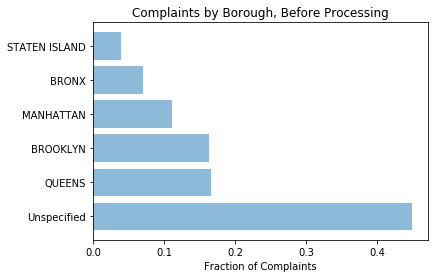

In [118]:
y = cdf.Borough.value_counts()[:-1] / cdf.shape[0]
x = y.index
y_pos = np.arange(len(x))

plt.barh(y_pos, y, align='center', alpha=0.5)
plt.yticks(y_pos, x)
plt.xlabel('Fraction of Complaints')
plt.title('Complaints by Borough, Before Processing')

In [119]:
def clean_address(address):
    '''
    Strip whitespace and convert string to upper
    '''
    try:
        return str.upper(address).strip()
    except:
        return None

def clean(df):
    '''
    Clean and filter the building dataframe
    Use only relevant columns and remove rows where YearBuilt==0
    '''
    df = df[['Address','XCoord','YCoord','ZipCode','YearBuilt','Borough']].copy()
    df['Address'] = df['Address'].apply(clean_address)
    df.drop(df[df['YearBuilt']==0].index,inplace=True)
    return df

def summary(df):
    '''
    Print percent null and top 10 most common values
    '''
    pct_null = df['Address'].isnull().sum()*1./df.shape[0]
    print "pct null:",round(pct_null,2)
    print df['Address'].value_counts().head(10)

# Neighborhoods

In [120]:
def import_neighborhoods(fname):
    '''
    import wikipedia neighborhoods file
    returns: dictionary where key is borough
        and value is list of neighborhoods
    '''
    with open(fname,'r') as f:
        raw = f.read()
    lines = raw.split('\n')
    boroughs = {}
    for line in lines:
        fields = line.split(',')
        borough = fields.pop(0)
        if borough not in boroughs:
            boroughs[borough]=[]
        for f in fields:
            if f:
                neighborhood = str.upper(f.strip())
                boroughs[borough].append(neighborhood)
    boroughs2 = {'QN':boroughs['Queens']+['QUEENS'],
                 'BK':boroughs['Brooklyn']+['BROOKLYN'],
                 'MN':boroughs['Manhattan']+['MANHATTAN','NEW YORK'],
                 'SI':boroughs['Staten Island']+['STATEN ISLAND'],
                 'BX':boroughs['Bronx']+['BRONX']}
    return boroughs2

In [121]:
def city2borough(city):
    for borough,hood_list in neighborhoods.iteritems():
        try:
            if str.upper(city) in hood_list:
                return borough
        except:
            return None

# Apply functions

In [123]:
#clean data
bdf = clean(bdf)

#clean up and rename address
cdf['Address'] = cdf['Incident Address'].apply(clean_address)

#import neighborhoods data
hoods_fname='../data/wiki_Neighborhoods_in_New_York_City.csv'
neighborhoods = import_neighborhoods(hoods_fname)
cdf['orig_borough'] = cdf['Borough'].copy()
cdf['Borough'] = cdf.City.apply(city2borough)
hdf = cdf[cdf['Complaint Type']=='HEATING']

## Many boroughs that were previously unspecified now are specified

In [126]:
pd.crosstab(cdf.Borough,cdf.orig_borough)

orig_borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,Unspecified
Borough,,,,,,
BK,0,15032,0,6,0,14885
BX,6038,1,1,1,0,14628
MN,1,6,9741,2,0,8814
QN,1,3,1,14387,0,4877
SI,0,0,0,135,3876,665


In [127]:
cdf.Borough.value_counts()

BK    29923
BX    20669
QN    19269
MN    18564
SI     4676
Name: Borough, dtype: int64

## Plot borough frequency after neighborhood mapping

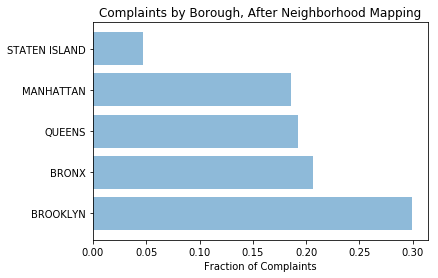

In [38]:
y = cdf.Borough.value_counts() / cdf.shape[0]
x = y.index
x = ['BROOKLYN','BRONX','QUEENS','MANHATTAN','STATEN ISLAND']
y_pos = np.arange(len(x))

plt.barh(y_pos, y, align='center', alpha=0.5)
plt.yticks(y_pos, x)
plt.xlabel('Fraction of Complaints')
plt.title('Complaints by Borough, After Neighborhood Mapping')

In [39]:
#Remove duplicates from buildings dataframe.  Only keep the newest one
bdf = bdf.sort_values(by='YearBuilt',ascending=False)
dupes = bdf.duplicated(subset=['Borough','Address'],keep='first')
bdf.drop(dupes[dupes].index,inplace=True)

In [40]:
#Merge buildings dataframe with heating dataframe
mdf = hdf.merge(bdf,how='inner',on=['Address','Borough'])

In [45]:
mdf2 = hdf.merge(bdf,how='left',on=['Address','Borough'])

In [41]:
print mdf.shape
print hdf.shape
print bdf.shape

(15853, 58)
(21655, 54)
(715058, 6)


In [44]:
hdf.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location,Address,borough2
1,12826511,01/01/2009 12:00:00 AM,01/07/2009 12:00:00 AM,HPD,Department of Housing Preservation and Develop...,HEATING,HEAT,RESIDENTIAL BUILDING,11237,1409 HANCOCK STREET,...,NaN,NaN,NaN,NaN,NaN,40.6959,-73.9076,"(40.69589152610558, -73.9075975573773)",1409 HANCOCK STREET,Unspecified
2,12826514,01/01/2009 12:00:00 AM,01/07/2009 12:00:00 AM,HPD,Department of Housing Preservation and Develop...,HEATING,HEAT,RESIDENTIAL BUILDING,10467,3204 HOLLAND AVENUE,...,NaN,NaN,NaN,NaN,NaN,40.8716,-73.8652,"(40.8715731645546, -73.8651936604682)",3204 HOLLAND AVENUE,Unspecified
3,12826518,01/01/2009 12:00:00 AM,01/08/2009 12:00:00 AM,HPD,Department of Housing Preservation and Develop...,HEATING,HEAT,RESIDENTIAL BUILDING,11226,131 EAST 21 STREET,...,NaN,NaN,NaN,NaN,NaN,40.6513,-73.9602,"(40.6512806982575, -73.96017059735964)",131 EAST 21 STREET,Unspecified
4,12826527,01/01/2009 12:00:00 AM,NaN,HPD,Department of Housing Preservation and Develop...,HEATING,HEAT,RESIDENTIAL BUILDING,10467,740 EAST GUN HILL ROAD,...,NaN,NaN,NaN,NaN,NaN,40.877,-73.8652,"(40.87696644472854, -73.86515379714511)",740 EAST GUN HILL ROAD,Unspecified
6,12826533,01/01/2009 12:00:00 AM,01/07/2009 12:00:00 AM,HPD,Department of Housing Preservation and Develop...,HEATING,HEAT,RESIDENTIAL BUILDING,11220,5813 4 AVENUE,...,NaN,NaN,NaN,NaN,NaN,40.6419,-74.0174,"(40.64185246137445, -74.0173643472391)",5813 4 AVENUE,Unspecified


## Calculate fraction of heating complaints that were lost in the join

In [43]:
mdf.shape[0]*1./hdf.shape[0]-1

-0.2679288847841145

In [42]:
counts = mdf.groupby(['YearBuilt']).count()

## More complaints from older buildings.  But are there just more older buildings?

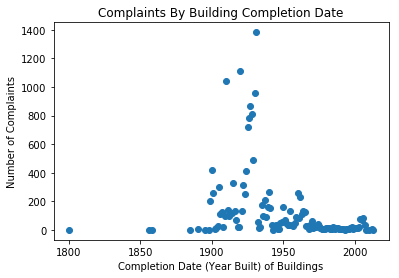

In [71]:
plt.scatter(counts.index,counts['Complaint Type'])
plt.title("Complaints By Building Completion Date")
plt.xlabel("Completion Date (Year Built) of Buildings")
plt.ylabel("Number of Complaints")

## Number of buildings by age

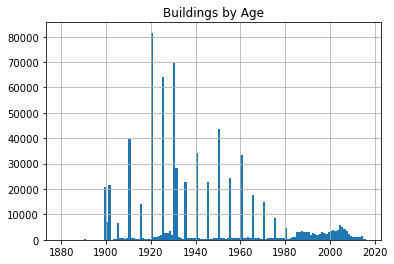

In [73]:
first_year = 1880
bdf.loc[bdf['YearBuilt']>=first_year,'YearBuilt'].hist(bins=2016-first_year)
plt.title('Buildings by Age')

In [74]:
building_counts = bdf.groupby('YearBuilt').count()['Borough']

In [75]:
counts['building_count']=building_counts

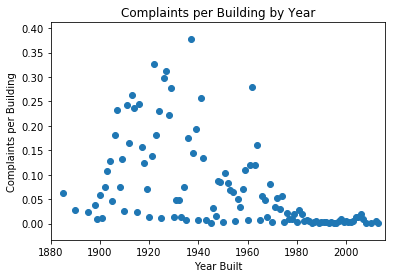

In [82]:
plt.scatter(counts.index,counts['Complaint Type']/counts['building_count'])
plt.xlim([1880,2016])
plt.title("Complaints per Building by Year")
plt.xlabel("Year Built")
plt.ylabel("Complaints per Building")

In [80]:
age = pd.read_csv('../data/complaints vs. age.csv')

In [83]:
age.head()

,Unnamed: 0,YearBuilt,total,Complaint Type,complaints
0,0,2001,3802,HEATING,772
1,1,1999,3186,HEATING,385
2,2,1889,16,HEATING,4
3,3,1951,644,HEATING,2160
4,4,1930,69439,HEATING,42534


In [84]:
age['complaints_per_building'] = age.complaints/age.total

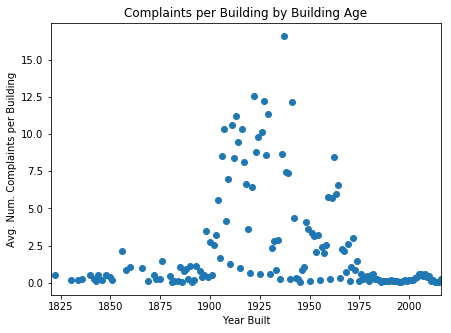

In [110]:
plt.figure(figsize=(7,5))
plt.scatter(age.YearBuilt,age.complaints_per_building)
plt.xlim([1820,2016])
plt.title("Complaints per Building by Building Age")
plt.xlabel("Year Built")
plt.ylabel("Avg. Num. Complaints per Building")